#### First, we need to import all the modules needed to run the code.

In [1]:
import pandas
import datetime
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

#### Next, we define some constants (such as month mappings and column names) that will help structure the analysis going forward.

In [2]:
_MTH_MAP = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
_GRD_MAP = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
_COL_ALL = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 
            'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
_COL_NUM = ['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'total_pymnt']
_COL_STR = list(set(_COL_ALL) - set(_COL_NUM))

#### We then load the raw loan data from a CSV file and restrict the output to the relevant columns

In [3]:
# Load the raw data
filename = r'/Users/tejsvirai/PycharmProjects/BX_case_study/BX_case_study_data/loan.csv'
data = pandas.read_csv(filepath_or_buffer = filename)

# Reindex to the requested subset of columns
data = data.reindex(columns = _COL_ALL)

# Delete variables we may reuse later
del filename

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### We next pre-process the data to append certain intermediate / useful information that will be used in the analysis later on. For example, we compute the annualized return for each loan in this step since we are asked to summarize this statistic in the "Business Analysis" part of the case study:

In [4]:
# Remove leading and trailing zeros from the loan term
term = list(map(lambda x: np.int(x.strip().split(' ')[0]), data['term'].values))

# Map the grades from letters to numbers
qual = list(map(lambda x: _GRD_MAP[x], data['grade'].values))

# Convert the issue_d into a pandas datetime
issue = list(map(lambda x: x.split('-'), data['issue_d']))
issue = list(map(lambda x: datetime.datetime(np.int(x[1]), _MTH_MAP[x[0]], 1), issue))
issue = list(map(lambda x: x + pandas.tseries.offsets.BMonthEnd(0), issue))

# Compute the maturity date from the issue date
expr = zip(issue, term)
expr = list(map(lambda x: x[0] + pandas.tseries.offsets.BMonthEnd(x[1]), expr))

# Add in dummies for whether the loan was paid off or not
dummy  = [1.0] * len(data.index)
isPaid = list(map(lambda x: 1.0 if 'fully paid' in x.lower() else 0.0, data['loan_status'].values))
yyyy   = list(map(lambda x: x.year, issue))
annRet = (data['total_pymnt'].values / data['funded_amnt'].values) ** (1 / 3) - 1.0

# Store the data
data['term_mm']  = term
data['grd_num']  = qual
data['issue_dt'] = issue
data['expr_dt']  = expr
data['dummy']    = dummy
data['ispaid']   = isPaid
data['yyyy']     = yyyy
data['avgRet']   = annRet

# Delete variables we might reuse later
del term, qual, issue, expr, dummy, isPaid, yyyy, annRet

#### We now move on to the main data visualization section where we get a first look at what our data actually consists of.

#### First, we look at the last 5 rows of our data for a quick visual inspection. We can see that the data is a mixture of numeric and text fields that is well-ordered and complete.

#### Each row in this table consists of one loan. For example, the first row correpsonds to a fully funded grade B loan for 10,000 with a 36 month term and issue date of Jan-2015. This loan is classified as current, has an interest rate of 11.99 percent and has been made to a borrower who has an annual income of 31,000.

In [5]:
display(data.tail(5))

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,term_mm,grd_num,issue_dt,expr_dt,dummy,ispaid,yyyy,avgRet
887374,10000.0,10000.0,36 months,11.99,B,31000.0,Jan-2015,28.69,14037.0,3971.88,Current,36,2,2015-01-30,2018-01-31,1.0,0.0,2015,-0.264924
887375,24000.0,24000.0,36 months,11.99,B,79000.0,Jan-2015,3.90,8621.0,9532.39,Current,36,2,2015-01-30,2018-01-31,1.0,0.0,2015,-0.264927
887376,13000.0,13000.0,60 months,15.99,D,35000.0,Jan-2015,30.90,11031.0,3769.74,Current,60,4,2015-01-30,2020-01-31,1.0,0.0,2015,-0.338105
887377,12000.0,12000.0,60 months,19.99,E,64400.0,Jan-2015,27.19,8254.0,3787.67,Current,60,5,2015-01-30,2020-01-31,1.0,0.0,2015,-0.319131
887378,20000.0,20000.0,36 months,11.99,B,100000.0,Jan-2015,10.83,33266.0,7943.76,Current,36,2,2015-01-30,2018-01-31,1.0,0.0,2015,-0.264924


#### Next, we summarize the data by looking at the range of values present in each column. This essentially takes all 887k+ loans in our data and presents the most salient features of the data column by column. Through this analysis, we can easily answer questions such as "what is the average notional of the loans in our database?" or "what is the maximum interest rate across all the loans the firm has issued?"

#### This sort of descriptive summary has two purposes:

#### a) It allows us to quickly see the possible range of values each of the loan attributes can take, which is helpful in detecting bad / missing / erroneous data
#### b) It allows us to quickly see if our data conforms to our intuitive understanding of the loan business

#### From this table, we can easily see that interest rates on our loans range between 5.32% and 28.99%, which seems reasonable and that the average loan amount is approximately 14,700.

In [6]:
# Test for outliers in the numeric data
_data = data.reindex(columns = _COL_NUM)
_data['funded_to_loan_ratio'] = _data['funded_amnt'] / _data['loan_amnt']
display(_data.describe().round(2))

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,funded_to_loan_ratio
count,887379.00,887379.00,887379.00,887375.00,887379.00,887379.00,887379.00,887379.00
mean,14755.26,14741.88,13.25,75027.59,18.16,16920.79,7558.83,1.00
std,8435.46,8429.90,4.38,64698.30,17.19,22426.79,7871.24,0.02
min,500.00,500.00,5.32,0.00,0.00,0.00,0.00,0.10
25%,8000.00,8000.00,9.99,45000.00,11.91,6443.00,1914.59,1.00
50%,13000.00,13000.00,12.99,65000.00,17.65,11875.00,4895.00,1.00
75%,20000.00,20000.00,16.20,90000.00,23.95,20829.00,10616.81,1.00
max,35000.00,35000.00,28.99,9500000.00,9999.00,2904836.00,57777.58,1.00


#### One drawback of our summary table above is that we cannot directly examine non-numeric data. In the analysis below, we look at the list of all possible values that the non-numeric data take our in data set.

#### From the output below, we see that the firm only issues loans with two kinds of terms: 36 months and 60 months. Moreover, there are 7 loan grades, ranging from A to G

In [7]:
# Check for the list of values possible in the non-numeric data
for c in ['term', 'grade']:
    print('Column ' + c + ': ' + str(sorted(list(set(data[c])))))

Column term: [' 36 months', ' 60 months']
Column grade: ['A', 'B', 'C', 'D', 'E', 'F', 'G']


#### Another drawback of the summary table is that when we have a lot of columns, it can be hard to detect patterns. Moreover, the summary table is not particularly visual. 

#### So, to take a look at the data graphically, we turn to histograms which excel at showing the range of possible values in the data. In a histogram, we first define buckets for a particular variable (say, loan interest rates) and then count how many loans fall into each bucket. This tells us whether most of our loans are relatively safe (that is, the proportion of loans in the 5% - 10% bucket is high) or are riskier (the proportion of loans in the 25% - 30% is high). We can (and do) plot a histogram for each numeric column we have and thus, analyze the distribution or range of each variable independently. 

<Figure size 432x288 with 0 Axes>

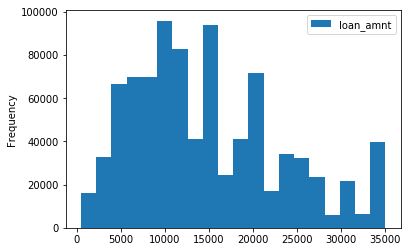

<Figure size 432x288 with 0 Axes>

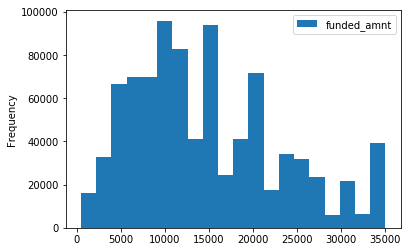

<Figure size 432x288 with 0 Axes>

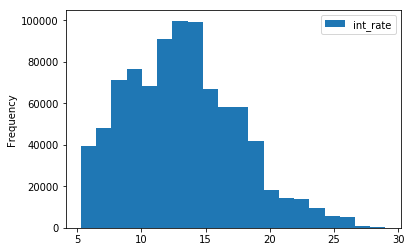

<Figure size 432x288 with 0 Axes>

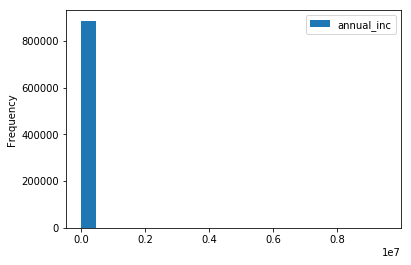

<Figure size 432x288 with 0 Axes>

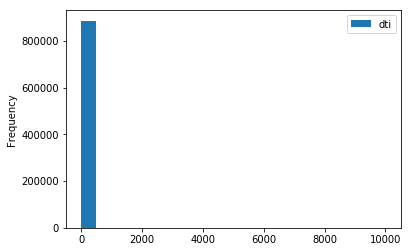

<Figure size 432x288 with 0 Axes>

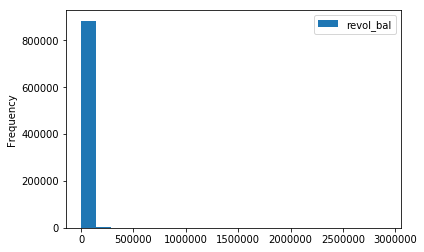

<Figure size 432x288 with 0 Axes>

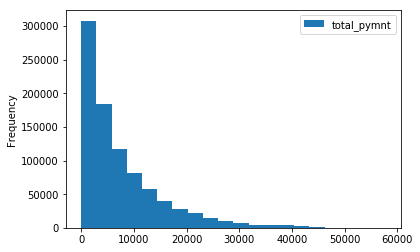

In [8]:
# Plot histograms of the numeric columnss
for c in _COL_NUM:
    plt.figure()
    _data = data.reindex(columns = [c]).plot.hist(bins = 20)
    plt.show()

#### We also use sorted line charts to complement the histograms. A sorted line chart sorts our data (say, loan interest rates) from low to high and then plots the values as an increasing line. The shape of this line can be pretty informative; if the line rises slowly and then shoots up to some high value, then we know that most of our loan interest rates are low. If the line shoots up to an unintuitive value however, we know that our data has outliers or errors.

<Figure size 432x288 with 0 Axes>

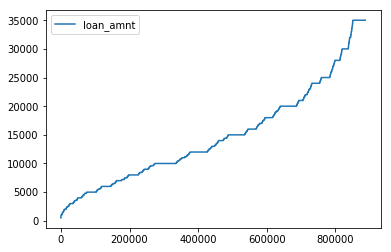

<Figure size 432x288 with 0 Axes>

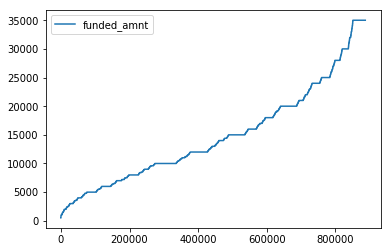

<Figure size 432x288 with 0 Axes>

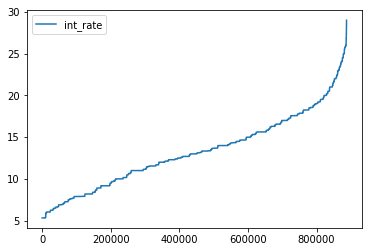

<Figure size 432x288 with 0 Axes>

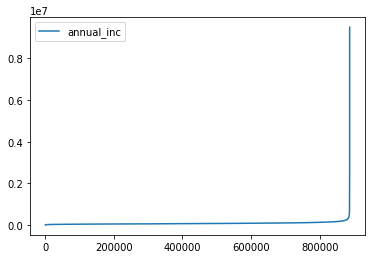

<Figure size 432x288 with 0 Axes>

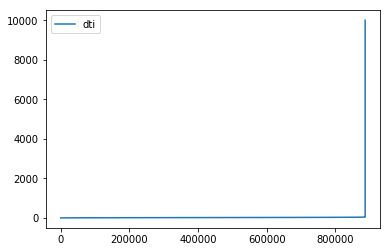

<Figure size 432x288 with 0 Axes>

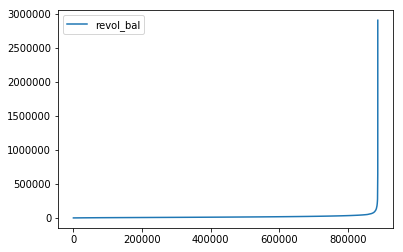

<Figure size 432x288 with 0 Axes>

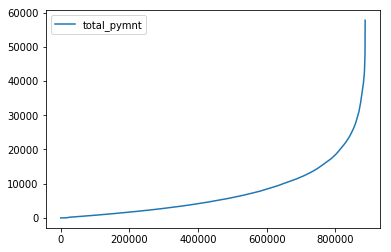

In [9]:
# Plot sorted line charts of the numeric columnss
for c in _COL_NUM:
    plt.figure()
    _data = data.reindex(columns = [c])
    _data = _data.sort_values(by = [c])
    _data = pandas.DataFrame(columns = [c], data = _data.values)
    _data.plot()
    plt.show()

#### Based on the findings from the summary table, the histogram charts and the sorted line charts, we perform some basic data cleaning as follows:

#### a) We set all debt-to-income (i.e. dti) values to missing if we have zero annual income (this affects only 2 loans)
#### b) We set a (high) ceiling on extremely high values of annual income (i.e. annual_inc), debt-to-income (i.e. dti) and revolving balance (i.e. revol_bal). This has little effect on the final results but makes our models much more stable

In [10]:
# ===========================================================
# Cell to clean the data
# ===========================================================

# Set DTI to missing if self-reported income is zero
data.loc[data['annual_inc'] == 0.0, 'dti'] = np.NaN

# Winsorize annual_inc, dti and revol_bal at the 99.9th percentile to avoid huge skew issues
for c in ['annual_inc', 'dti', 'revol_bal']:
    quantile = data[c].quantile([0.999]).values[0]
    data.loc[data[c] >= quantile, c] = quantile

# Delete variables we might reuse later
del c, quantile

#### Next, we continue our data exploration by taking the concept of the summary table one step further. Specifically, the summary table gave us an idea of the ranges of our data across the entire spectrum of loans. But, what if we wanted to know the average interest rate by each of the seven grades of loans? Or, perhaps, the total number of loans issued by year? 

#### To answer these sorts of questions, we compute a "grouped" summary table, where we summarize our loan characteristics within each group (vs. over the entire universe or loans)

#### The first grouping we analyze is the year of issuance, which allows us to see how the loan volumes have changed over time. From this, we can see that total issuance has increased dramatically since 2007 (the "dummy" column), while average loan interest rates and borrower incomes have remained relatively stable over time. Moreover, the percentage of loans fully paid off (the "ispaid" column) remains relatively steady (and high) except for the last 3 years, which makes sense since a lot of the loans issued recently are still outstanding.

In [11]:
group = data.groupby(by = ['yyyy'])
group = group.agg({'dummy': np.sum, 'int_rate': np.mean, 'loan_amnt': np.mean, 'annual_inc': np.mean, 'ispaid': np.mean})
display(group.round(2))
del group

,dummy,int_rate,loan_amnt,annual_inc,ispaid
yyyy,,,,,
2007,603.0,11.83,8254.52,64521.88,0.74
2008,2393.0,12.06,8825.43,64547.14,0.79
2009,5281.0,12.44,9833.03,68349.27,0.86
2010,12537.0,11.99,10528.24,68077.61,0.86
2011,21721.0,12.22,12047.50,69256.43,0.76
2012,53367.0,13.64,13461.71,69362.25,0.78
2013,134755.0,14.53,14708.09,73034.93,0.42
2014,235628.0,13.77,14870.18,74575.66,0.23
2015,421094.0,12.60,15240.26,76314.64,0.05


#### The next grouping we analyze is the loan grade which reveals some interesting (and intuitive) characteristics of the data. Specifically, interest rates rise as we go from grade A to grade G, indicating that grade A loans are the safest. Moreover, the total issuance is concentrated in grades A - D, indicating that the firm mostly makes relatively safe loans. In fact, the total number of grade G loans ever issued is a paltry 5,489 (out of a total of 887,379 loans!)

In [12]:
group = data.groupby(by = ['grade'])
group = group.agg({'dummy': np.sum, 'int_rate': np.mean, 'loan_amnt': np.mean, 'annual_inc': np.mean, 'ispaid': np.mean})
display(group.round(2))
del group

,dummy,int_rate,loan_amnt,annual_inc,ispaid
grade,,,,,
A,148202.0,7.24,14038.86,86095.61,0.27
B,254535.0,10.83,13642.97,74995.09,0.26
C,245860.0,13.98,14466.31,71173.63,0.22
D,139542.0,17.18,15459.51,68887.74,0.22
E,70705.0,19.90,17998.15,71731.06,0.19
F,23046.0,23.58,19139.16,73581.18,0.21
G,5489.0,25.63,20538.56,79440.03,0.23


#### The next grouping we analyze is a combination of issuance year and loan term. This allows us to see how the firm's mix of business has changed over time. We notice that, at the start of the dataset, the firm only made 36 month loans and expanded into 60 month loans in 2010. That said, even as of 2015, the majority of the firm's business (283k out of 420k loans, or 67%) was in the 36 month loan market.

In [13]:
group = data.groupby(by = ['yyyy', 'term'])
group = group.agg({'dummy': np.sum, 'int_rate': np.mean, 'loan_amnt': np.mean, 'annual_inc': np.mean, 'ispaid': np.mean})
display(group.round(2))
del group

dummy  int_rate  loan_amnt  annual_inc  ispaid
yyyy term                                                         
2007  36 months     603.0     11.83    8254.52    64521.88    0.74
2008  36 months    2393.0     12.06    8825.43    64547.14    0.79
2009  36 months    5281.0     12.44    9833.03    68349.27    0.86
2010  36 months    9156.0     11.31    9801.32    67343.68    0.89
      60 months    3381.0     13.83   12496.79    70065.15    0.77
2011  36 months   14101.0     10.55    9421.14    66392.84    0.89
      60 months    7620.0     15.31   16907.66    74555.58    0.51
2012  36 months   43470.0     12.63   11681.60    66728.34    0.86
      60 months    9897.0     18.08   21280.38    80931.03    0.40
2013  36 months  100380.0     13.37   12668.17    70831.71    0.46
      60 months   34375.0     17.93   20664.96    79468.66    0.31
2014  36 months  162569.0     12.47   12585.61    72177.37    0.26
      60 months   73059.0     16.67   19953.73    79912.26    0.18
2015  36 months  283172.0     11.28   12806.47    73829.48    0.06
      60 months  137922.0     15.32   20237.14    81416.99    0.05

#### The final grouping we analyze is a combination of issuance year and loan grade where we document that the number of loans issued, the average interest rate and the percentage of loans paid decline, increase and decline respectively as we go from grades A to G across most of the years in our dataset. This tells us that the data is not only intuitive in aggregate but is also broadly consistent across a period where the firm's business was expanding rapidly.

In [14]:
display(data.groupby(by = ['yyyy', 'grade']).agg({'dummy': np.sum}).unstack().round(0))
display(data.groupby(by = ['yyyy', 'grade']).agg({'int_rate': np.mean}).unstack().round(1))
display(data.groupby(by = ['yyyy', 'grade']).agg({'ispaid': np.mean}).unstack().round(2))

dummy                                                      
grade        A         B         C        D        E       F       G
yyyy                                                                
2007      78.0      98.0     141.0     99.0    100.0    52.0    35.0
2008     318.0     594.0     580.0    419.0    285.0   111.0    86.0
2009    1203.0    1445.0    1348.0    817.0    308.0   105.0    55.0
2010    2830.0    3687.0    2729.0   1885.0    962.0   311.0   133.0
2011    5754.0    6565.0    3942.0   2796.0   1739.0   722.0   203.0
2012   10901.0   18507.0   11875.0   7323.0   3185.0  1315.0   261.0
2013   17675.0   44098.0   38113.0  20558.0   9057.0  4390.0   864.0
2014   36108.0   61935.0   66565.0  42991.0  20121.0  6223.0  1685.0
2015   73335.0  117606.0  120567.0  62654.0  34948.0  9817.0  2167.0

int_rate                                    
grade        A     B     C     D     E     F     G
yyyy                                              
2007       7.8   9.4  10.8  12.6  14.1  15.6  17.4
2008       8.4  10.4  11.8  13.4  14.8  16.3  18.1
2009       8.6  11.8  13.3  14.9  16.5  18.2  20.0
2010       7.1  10.7  13.5  15.3  16.9  18.7  20.7
2011       7.1  11.1  13.9  16.4  18.4  20.4  22.0
2012       7.6  12.2  15.3  18.4  21.1  23.1  24.5
2013       7.7  11.8  15.5  18.7  21.7  24.0  25.5
2014       7.5  11.2  14.2  17.1  20.4  24.2  25.9
2015       6.9  10.0  13.3  16.7  19.3  23.6  26.8

ispaid                                    
grade      A     B     C     D     E     F     G
yyyy                                            
2007    0.95  0.84  0.76  0.69  0.69  0.52  0.51
2008    0.94  0.83  0.79  0.74  0.74  0.66  0.67
2009    0.93  0.88  0.85  0.82  0.78  0.73  0.67
2010    0.95  0.88  0.85  0.79  0.75  0.69  0.67
2011    0.92  0.79  0.70  0.64  0.55  0.49  0.51
2012    0.92  0.83  0.75  0.67  0.48  0.43  0.39
2013    0.47  0.46  0.40  0.39  0.34  0.32  0.33
2014    0.24  0.25  0.23  0.22  0.21  0.22  0.21
2015    0.04  0.05  0.06  0.06  0.07  0.08  0.10

#### Next, using the data above, we answer three key questions relevant to the business

In [15]:
# Restrict the data to only contain the 36 month loans
data = data.loc[data['term_mm'].values == 36, :]

# Convert the issue_d into a pandas datetime and assume that the maximum issue date is the current date
today = max(data['issue_dt'].values)
flag = np.array(list(map(lambda x: x <= today, data['expr_dt'].values)))
data = data.loc[flag, :]

# Question 1:
fullyPaid = data['ispaid'].sum() / data['dummy'].sum()

# Question 2:
groups = data.groupby(by = ['yyyy', 'grade'])
cohort = groups.sum()
cohort = 1.0 - cohort['ispaid'] / cohort['dummy']
cohort = cohort.sort_values()
cohort = cohort.index[-1]

# Question 3:
avgRet = groups.mean()['avgRet']

# Print answers to the questions
print('Business Analysis Output:')
print('================================================')
print('Question 1: The percentage of loans that has been fully paid is: ' + str(np.round(fullyPaid, 1) * 100) + '%')
print('Question 2: The most deliquent cohort is: ' + str(cohort))
print('Question 3: The average return by cohort is:')
display((avgRet * 100.0).unstack().round(1))
print('================================================')
print('')

# Delete variables we might reuse later
del today, flag, groups

Business Analysis Output:
Question 1: The percentage of loans that has been fully paid is: 90.0%
Question 2: The most deliquent cohort is: (2007, 'G')
Question 3: The average return by cohort is:


grade,A,B,C,D,E,F,G
yyyy,,,,,,,
2007,2.7,-0.2,-0.8,-1.4,-1.5,-8.0,-4.4
2008,2.3,-0.0,-0.5,-1.8,-0.3,-4.5,-0.8
2009,2.1,1.4,1.2,1.4,-0.0,0.3,0.3
2010,2.2,2.2,2.2,1.3,1.4,-0.8,-0.8
2011,1.5,2.2,1.8,2.1,2.4,2.2,-2.0
2012,1.6,2.3,2.2,2.4,3.2,3.2,4.3


#### From the table above, we can see clearly that the average return generally declines with loan quality in the recession years but actually increases in the post-crisis years. This makes sense as a lot of the lower quality loans that were made heading into the recession were probably not paid off (i.e. the higher interest rates on those loans didn't adequately cover the default risk) while the riskier credits from later in the sample were more likely to be repaid in full. 

#### As a result, the most delinquent cohort is the 2007 / G grade loans, which were the riskiest loans made right before the financial crisis.

#### In general however, we find that most loans (approximately 86.9%) are repaid in full

#### Next, we build a model to predict which loans are going to default. We define a default as any loan that has not been fully paid off by the end of its term

#### We use a logistic regression model to predict defaults. This kind of model essentially takes in several loan characteristics (say, loan interest rates, borrower debt-to-income ratios, loan amounts etc.) and examines the joint impact of all these variables on defaults. In other words, a model like this can answer questions such as "do higher interest rates on a loan correlate with a higher likelihood of default" or "are lower loan amounts associated with a reduction in default rates"

#### The inputs to the logistic regression model are loan characteristics (or features) and the choice of features is therefore critical to the model's performance. Ideally, we would select features that are not only intuitive but also correlate strongly with defaults.

In [16]:
# Drop data with NaNs
data['lti'] = data['loan_amnt'] / data['annual_inc']
data = data.reindex(columns = ['int_rate', 'grd_num', 'dti', 'lti', 'ispaid'])
data = data.dropna(how = 'any', axis = 0)

# Extract out some relevant features
X = data.reindex(columns = ['int_rate', 'grd_num', 'dti', 'lti'])
Y = data['ispaid']

#### To identify whether a particular loan characteristic is suitable, we turn once again to our grouped summary tables. In this case, the grouping mechanism is whether a loan is fully paid off (ispaid = 1) or has defaulted (ispaid = 0).

#### From the table below, we see that loans that default (ispaid = 0) have, on average, a riskier (higher) grade number (grade A = 1, grade G = 7) and a higher interest rate. These loans also tend to be made to people with lower incomes and higher debt to income ratios.

,dti,grd_num,int_rate,lti
ispaid,,,,
0.0,16.02,2.76,13.47,0.20
1.0,14.86,2.24,11.82,0.18


<Figure size 432x288 with 0 Axes>

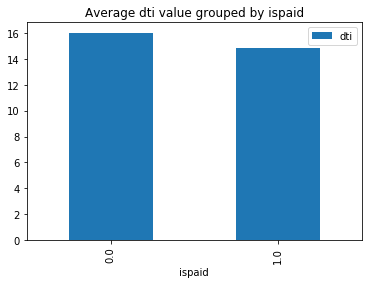

<Figure size 432x288 with 0 Axes>

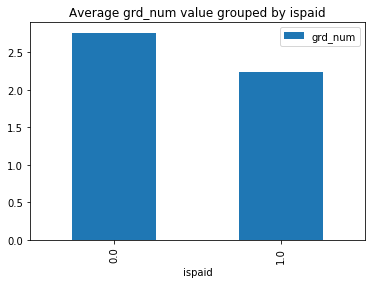

<Figure size 432x288 with 0 Axes>

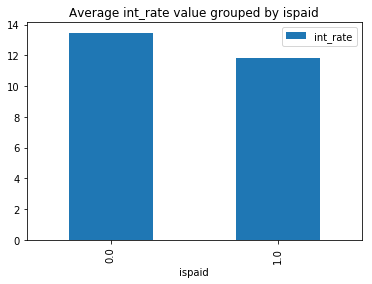

<Figure size 432x288 with 0 Axes>

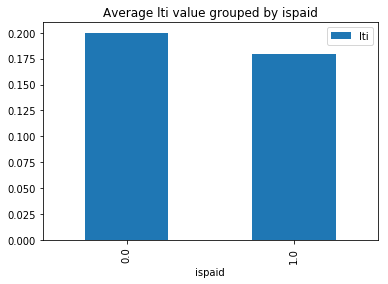

In [17]:
# Plot averages by ispaid groups
grouped = data.groupby(by = ['ispaid']).describe().xs(key = 'mean', axis = 1, level = 1).round(2)
display(grouped)
for c in grouped.columns:
    plt.figure()
    grouped.reindex(columns = [c]).plot(kind = 'bar', title = 'Average ' + c + ' value grouped by ispaid')
    plt.show()                         

#### Another way to visualize whether or not a particular characteristic is suitable for inclusion in the model is to check its correlation with other characteristics and with the default variable (i.e. ispaid). Since a correlation is just a way to measure how two variables move together (positive correlation = positive association), we are looking for two things here:

#### a) Variables that correlate with the default rate (i.e. if we expect high loan interest rates to lead to a low probability of payment, then we should look for a negative association between the variables int_rate and ispaid)

#### b) Variables that are too similar (i.e very high or low correlation). This is important because our model doesn't handle these kinds of situations well.

#### From the table below, we can see that the loan interest rate (i.e. int_rate), the loan grade (i.e. grad_num), loan to income (lti) and debt to income (i.e. dti) are all negatively correlated with ispaid, our outcome of interest. However, the loan interest rate and the loan grade are very similar, so we should only include one of them in the analysis. We choose the interest rate since its a more granular measure of loan risk.

,int_rate,grd_num,dti,lti,ispaid
int_rate,1.00,0.90,0.16,0.14,-0.15
grd_num,0.90,1.00,0.09,0.10,-0.15
dti,0.16,0.09,1.00,0.19,-0.05
lti,0.14,0.10,0.19,1.00,-0.07
ispaid,-0.15,-0.15,-0.05,-0.07,1.00


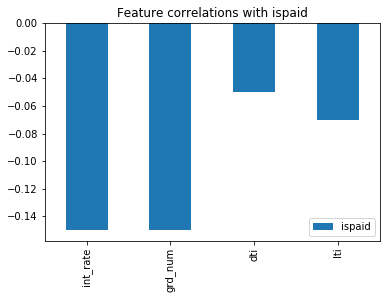

In [18]:
corr = data.corr().round(2)
display(corr)
del corr['ispaid']
corr = corr.reindex(index = ['ispaid']).T
corr.plot(kind = 'bar', title = 'Feature correlations with ispaid')

#### Now that we have narrowed down our features to loan interest rate, debt-to-income ratio and loan-to-income ratio, we can proceed with estimating our regression model. To do this, we use 80% of the data to come up with the model and use the other 20% to see how good the model is after it has been built

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


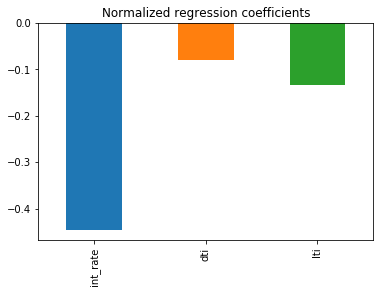

In [19]:
# Drop correlated variables
del X['grd_num']

# Split the data set into training and test sets
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.20)

# Fit the logistic regression model
regress = LogisticRegression(class_weight = 'balanced')
regress.fit(X = XTrain, y = YTrain)

# Predict output on the testing sets
YPred = regress.predict(X = XTest)

# Generate the confusion matrix
conf = confusion_matrix(y_true = YTest, y_pred = YPred)
conf = pandas.DataFrame(index = ['true_0', 'true_1'], columns = ['pred_0', 'pred_1'], data = conf)

# Generate standardized output
accuracy  = accuracy_score(y_true = YTest, y_pred = YPred)
precision = precision_score(y_true = YTest, y_pred = YPred)
recall    = recall_score(y_true = YTest, y_pred = YPred)

# Get normalized coefficient values
coef_norm = pandas.Series(index = X.columns, data = regress.coef_[0] * X.std().values)
coef_norm.plot(kind = 'bar', title = 'Normalized regression coefficients')

#### From the model output above, we can see that the most important feature is the interest rate (i.e. int_rate). In other words, the single biggest predictor of whether a loan is going to default or not is how high the interest rate is / how risky the loan is. This makes intuitive sense since the loan interest rate is directly related to the cost of servicing the loan.

#### We also note that our other two variables, loan-to-income (i.e. lti) and debt-to-income (i.e. dti) play a smaller but non-trivial role in the analysis

In [20]:
print('Logistic Regression Output')
print('================================================')
print('Accuracy:  ' + str(np.round(accuracy * 100.0, 1)) + '%')
print('Precision: ' + str(np.round(precision * 100.0, 1)) + '%')
print('Recall:    ' + str(np.round(recall * 100.0, 1)) + '%')
print('Confusion matrix:')
print(conf.to_string())
print('Confusion matrix normalized:')
print((100.0 * conf / conf.sum().sum()).round(1).to_string())
print('================================================')
print('')

Logistic Regression Output
Accuracy:  59.0%
Precision: 90.8%
Recall:    58.6%
Confusion matrix:
        pred_0  pred_1
true_0    1232     768
true_1    5381    7619
Confusion matrix normalized:
        pred_0  pred_1
true_0     8.2     5.1
true_1    35.9    50.8



#### Although the regression features seem to capture how loans work, we still don't really know if this model is any good. In order to do this, we must use the 20% of the data that we didn't let the model see. We do this by checking how well the model's predictions (i.e. do we expect a particular loan to default or not) match up with what actually happened to the loan (i.e. did that particular loan actually default or not) in the 20% of the data that was intially withheld from the model.

#### Intuitively, the perfect model should always predict a default for loans that actually default and also always predict a no-default for loans that do not actually default. However, because real world models are always error-prone, a reasonable model is one that doesn't make too many mistakes.

#### For our purposes, the point of this model is to find a way to only invest in loans that are likely to be good. As a result, we want a model where most of the predictions about a loan being good actually come true. It turns out that our model has an approximately 90% success rate on this metric, meaning that 9 out of 10 times, a loan that the model thinks is good will actually end up being good. This ultimately means that the model is a pretty reliable guide on which loans are actually going to be repaid.

#### However, the model does have one drawback in that it doesn't always identify all the good loans that are out there in the world. In other words, it leaves a lot of missed opportunities on the table, to the tune of about 40% of all truly good loans.

#### To summarize, this model doesn't see about 40% of all the truly good loans out there; of the 60% of good loans out there, it correctly identifies about 90% of them. As a result, this model is a reliable but not comprehensive indicator of which loans are likely to be repaid in full at the end of their term and is a reasonble tool to use in an investment process.